In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
drivers = pd.read_csv('archive/drivers.csv')
standings = pd.read_csv('archive/driver_standings.csv')
results = pd.read_csv('archive/results.csv')
races = pd.read_csv('archive/races.csv')

In [3]:
standings = standings.merge(races[['raceId', 'year']], on='raceId')
total_races = results.groupby('driverId')['raceId'].count().reset_index(name='total_races')
total_wins = standings.groupby('driverId')['wins'].sum().reset_index(name='total_wins')

points_seasons = standings.groupby('driverId').agg(
    total_points=('points', 'sum'),
    seasons=('year', lambda x: len(set(x)))
).reset_index()

podiums = results[results['positionOrder'] <= 3].groupby('driverId').size().reset_index(name='total_podiums')
summary = drivers[['driverId', 'forename', 'surname', 'nationality']].copy()
summary = summary.merge(total_races, on='driverId')
summary = summary.merge(total_wins, on='driverId')
summary = summary.merge(points_seasons, on='driverId')
summary = summary.merge(podiums, on='driverId', how='left')
summary.fillna(0, inplace=True)

In [4]:
summary['win_ratio'] = summary['total_wins'] / summary['total_races']
summary['podium_ratio'] = summary['total_podiums'] / summary['total_races']
summary['avg_points_per_season'] = summary['total_points'] / summary['seasons']

summary.replace([float('inf'), -float('inf')], 0, inplace=True)
summary.fillna(0, inplace=True)

features = summary[['win_ratio', 'podium_ratio', 'avg_points_per_season']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

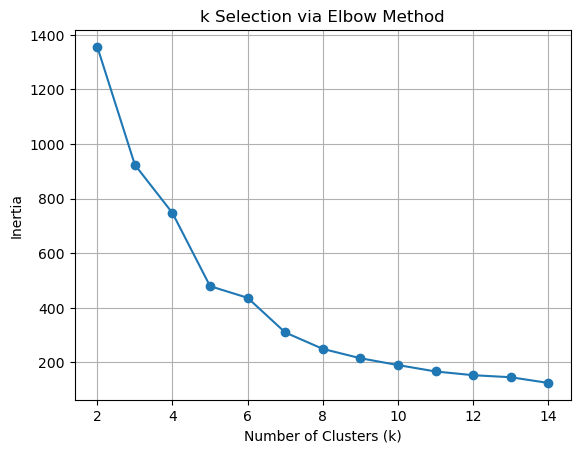

In [5]:
inertia = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia, marker='o')
plt.title('k Selection via Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [8]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto")
summary['cluster'] = kmeans.fit_predict(X_scaled)

In [9]:
print("Number of drivers per cluster:")
print(summary["cluster"].value_counts().sort_index())

print("\nRandom sample of 5 drivers in each cluster:")
for cluster_id, group in summary.groupby("cluster"):
    sample = group.sample(n=5) if len(group) >= 5 else group
    names = sample[['forename', 'surname']].agg(' '.join, axis=1).to_list()
    print(f"Cluster {cluster_id}: {names}")

Number of drivers per cluster:
cluster
0     57
1    781
2     14
3      2
Name: count, dtype: int64

Random sample of 5 drivers in each cluster:
Cluster 0: ['Mika Häkkinen', 'Bruce McLaren', 'Emerson Fittipaldi', 'Alan Jones', 'Mauri Rose']
Cluster 1: ['Tony Marsh', 'Alessandro Nannini', 'Peter Ryan', 'Ralph Firman', 'Alfonso Thiele']
Cluster 2: ['Sergio Pérez', 'George Russell', 'Lando Norris', 'Kimi Räikkönen', 'Nico Rosberg']
Cluster 3: ['Lewis Hamilton', 'Max Verstappen']
